In [2]:
!pip uninstall -y pandas numpy scikit-learn ydata-profiling
!pip install pandas==2.1.4 numpy==1.24.4 scikit-learn==1.3.2 ydata-profiling==4.6.4

Found existing installation: pandas 2.1.4
Uninstalling pandas-2.1.4:
  Successfully uninstalled pandas-2.1.4
Found existing installation: numpy 1.24.4
Uninstalling numpy-1.24.4:
  Successfully uninstalled numpy-1.24.4
Found existing installation: scikit-learn 1.3.2
Uninstalling scikit-learn-1.3.2:
  Successfully uninstalled scikit-learn-1.3.2
Found existing installation: ydata-profiling 4.6.4
Uninstalling ydata-profiling-4.6.4:
  Successfully uninstalled ydata-profiling-4.6.4
  Using cached pandas-2.1.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
  Using cached scikit_learn-1.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached ydata_profiling-4.6.4-py2.py3-none-any.whl.metadata (20 kB)
Using cached pandas-2.1.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.2 MB)
Using cached numpy-1.24.4-cp31

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Profiling report generated → red_wine_profile.html
📊 Model Evaluation Results:
                 Model     AUC  Accuracy
0             Baseline  0.5000    0.5289
1  Logistic Regression  0.8722    0.7881
2          Naive Bayes  0.8890    0.8196
3        Decision Tree  0.8156    0.8109
4         SVM - Linear  0.8746    0.7916
5            SVM - RBF  0.9217    0.8354
6        Random Forest  0.9216    0.8511


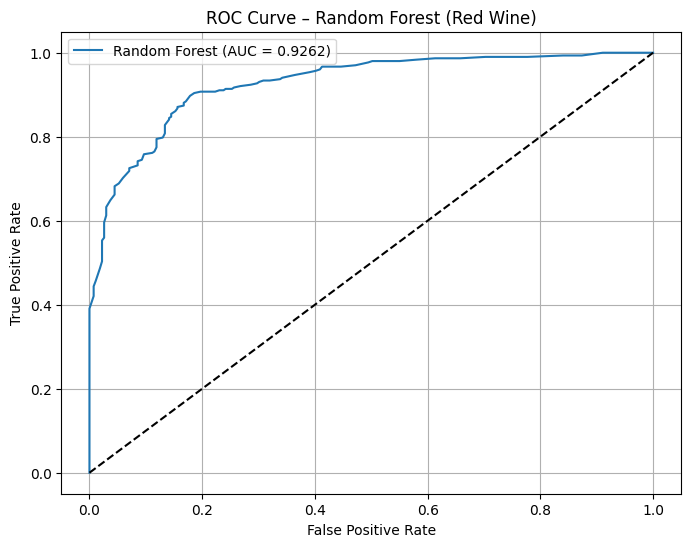

📈 AUC of Naive Bayes on White Wine Dataset: 0.9489


In [1]:
# ✅ Imports
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

# ✅ Load Data
red_wine = pd.read_csv('/content/red_wine.csv')
white_wine = pd.read_csv('/content/white_wine.csv')

# ✅ Clean column names
red_wine.columns = red_wine.columns.str.strip()
white_wine.columns = white_wine.columns.str.strip()

# ✅ Convert 'type' column to binary label: high = 1, low = 0
red_wine['quality'] = red_wine['type'].map({'low': 0, 'high': 1})
white_wine['quality'] = white_wine['type'].map({'low': 0, 'high': 1})

# ✅ Drop 'type' column
red_wine = red_wine.drop(columns=['type'])
white_wine = white_wine.drop(columns=['type'])

# ✅ Generate profiling report
profile = ProfileReport(red_wine, title="Red Wine Profiling Report", explorative=True)
profile.to_file("red_wine_profile.html")
print("✅ Profiling report generated → red_wine_profile.html")

# ✅ Prepare features and labels
X = red_wine.drop('quality', axis=1)
y = red_wine['quality']

# ✅ Define models
models = {
    'Baseline': DummyClassifier(strategy='most_frequent'),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM - Linear': SVC(kernel='linear', probability=True),
    'SVM - RBF': SVC(kernel='rbf', probability=True),
    'Random Forest': RandomForestClassifier()
}

# ✅ 10-fold CV and evaluation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
results = []

for name, model in models.items():
    if 'SVM' in name:
        pipeline = make_pipeline(StandardScaler(), model)
    else:
        pipeline = model
    y_pred = cross_val_predict(pipeline, X, y, cv=kf, method='predict')
    y_proba = cross_val_predict(pipeline, X, y, cv=kf, method='predict_proba')[:, 1]
    acc = accuracy_score(y, y_pred)
    auc_score = roc_auc_score(y, y_proba)
    results.append((name, round(auc_score, 4), round(acc, 4)))

# ✅ Display results
results_df = pd.DataFrame(results, columns=['Model', 'AUC', 'Accuracy'])
print("📊 Model Evaluation Results:")
print(results_df)

# ✅ Plot ROC Curve for Random Forest
rf_model = make_pipeline(StandardScaler(), RandomForestClassifier())
y_rf_proba = cross_val_predict(rf_model, X, y, cv=kf, method='predict_proba')[:, 1]
fpr, tpr, thresholds = roc_curve(y, y_rf_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Random Forest (AUC = %0.4f)' % roc_auc_score(y, y_rf_proba))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Random Forest (Red Wine)')
plt.legend()
plt.grid()
plt.show()

# ✅ Test best model (e.g. Naive Bayes) on white wine
X_white = white_wine.drop('quality', axis=1)
y_white = white_wine['quality']

nb_model = GaussianNB()
nb_model.fit(X, y)
white_preds = nb_model.predict_proba(X_white)[:, 1]
white_auc = roc_auc_score(y_white, white_preds)
print(f"📈 AUC of Naive Bayes on White Wine Dataset: {white_auc:.4f}")